In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats

import scipy.optimize as spopt

In [2]:
from resonator_tools.circuit import notch_port

In [3]:
def db2mag(db): return np.power(10, db/20)

def set_power_scan(pows_exper, mag, pha): 
    #normalization 

    mag_m1colomn = mag-mag[:,0][np.newaxis].T  #  mag_m1colomn: (4001, 102)
    mag_db = db2mag(mag_m1colomn)              #        mag_db: (4001, 102)
    S21_abs = mag_db[:,1:]                     #       S21_abs: (4001, 101)

    pha_m1colomn = pha-pha[:,0][np.newaxis].T   # pha_m1colomn: (4001, 102)
    phi_raw = pha_m1colomn[:,1:]                # phi_raw: (4001, 101)
    S21_phi = np.angle(np.exp(1j*phi_raw))      # smoothing out phase jumps

    powers = pows_exper[1:]                     # powers: (101,)
    return S21_abs, S21_phi, powers

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


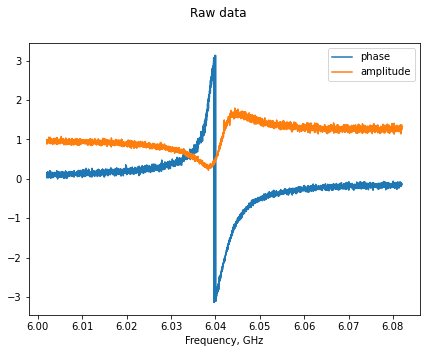

In [18]:
adress_file = r"C:\Users\mukha\Downloads\Gain_12.084202104232356GHz.mat"  #1


mat = scipy.io.loadmat(adress_file)
freqs, mag, pha, Gain, pows_exper = np.array(mat['f'][0]),  np.array(mat['mag']),  np.array(mat['pha']),  np.array(mat['Gain']), np.array(mat['SignalGeneratorPumpP'][0])

S21_abs, S21_phi, powers = set_power_scan(pows_exper, mag, pha) 

S21 = S21_abs*np.exp(1j*S21_phi)

fig, ax = plt.subplots(figsize=(7,5)) 
ax.plot(freqs/1e9, S21_phi[:,1], label = 'phase')
ax.plot(freqs/1e9, S21_abs[:,1], label = 'amplitude')
plt.suptitle('Raw data')
plt.xlabel('Frequency, GHz')
ax.legend()

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


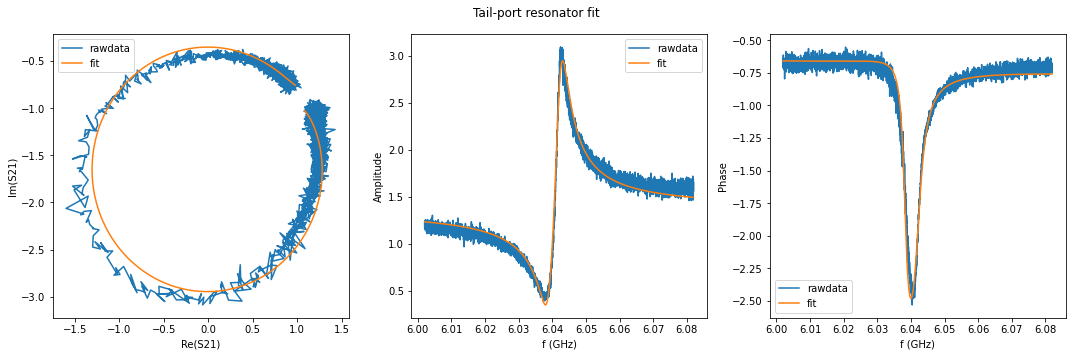

{'Qi_dia_corr': 2642.9586847633755,
 'Qi_no_corr': -1631.687947523212,
 'absQc': 772.7892258640345,
 'Qc_dia_corr': 3302.64323272423,
 'Ql': 1468.1019240339497,
 'fr': 6039104334.123162,
 'theta0': -1.8057181476589979,
 'phi0': 1.3346155645308055,
 'chi_square': 0.005384865907150856,
 'delay': 1.11131050188089e-10,
 'a': 1.3654338991558792,
 'alpha': -2.7698696411687975}

In [8]:
S = S21[:,-88]


# circle fit
T = notch_port(freqs, S)
f_tail, S_fit, fitresults = T.tail_port(freqs, S, plot = True )
fitresults

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


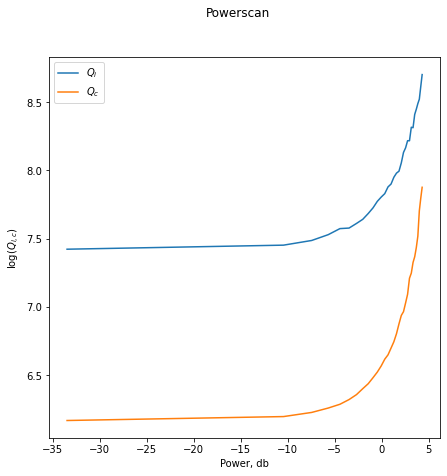

In [23]:
fr = np.array([])
Ql = np.array([])
Qc = np.array([])
Qi = np.array([])

for i in range(0, len(powers)-70):
    S = S21[:,i]
    
    T = notch_port(freqs, S)
    f_tail, S_fit, fitresults = T.tail_port(freqs, S)
    
    fr = np.append(fr, fitresults['fr']/1e9)
    Ql = np.append(Ql, fitresults['Ql'])
    Qc = np.append(Qc, fitresults['absQc'])
    Qi = np.append(Qi, fitresults['Qi_dia_corr'])

fig, ax = plt.subplots(figsize=(7,7)) 
ax.plot(powers[:-70], np.log(Qi), label = r'$Q_{i}$')
ax.plot(powers[:-70], np.log(Qc), label = r'$Q_{c}$')
plt.suptitle('Powerscan')
plt.ylabel(r'log($Q_{i, c}$)')
plt.xlabel('Power, db')
ax.legend()